# Small-Scale NDVI Calculation

In [1]:
import folium
import sentinel_helpers
from pathlib import Path

tempelhofer_feld = sentinel_helpers.search_osm('Tempelhofer Feld, Berlin, Germany').iloc[:1]

## Verify the Obtained Geometry

We introduce the `folium` library which lets us plot an OpenStreetMap-based map in the background.
This enables us a better preview of our shape, because it allows us to surrounding features such as streets or parks.

There is a helper to plot a GeoDataframe on a folium map with a single function call:  

In [4]:
from sentinel_helpers import geodataframe_on_map
??geodataframe_on_map

Signature: plot_on_map(geodataframe)
Source:   
def plot_on_map(geodataframe):
    '''
    Generate a folum map that displays a single-elment GeoDataframe.
    '''
    bbox = geodataframe.bounds.values[0]
    minx, miny, maxx, maxy = bbox
    m = folium.Map([0, 0], tiles='cartodbpositron')
    folium.GeoJson(geodataframe.to_json()).add_to(m)
    m.fit_bounds([[miny, minx], [maxy, maxx]])
    return m
File:      ~/true-color-image/sentinel_helpers.py
Type:      function


In [5]:
geodataframe_on_map(tempelhofer_feld)

In [5]:
base_path = Path('input/tempelhofer_feld')
base_path.mkdir(exist_ok=True, parents=True)

tempelhofer_feld.to_file(base_path / 'tempelhofer_feld.geojson', driver='GeoJSON')

Let's search for all images that give us a reasonably clear view of the Tempelhofer Feld in 2019.

In [6]:
from datetime import date
from sentinelsat import SentinelAPI
from shapely.geometry import box
from tqdm.notebook import tqdm
import os

In [7]:
api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))
api._tqdm = tqdm # monkey-patch for nicer progress bars

In [8]:
footprint = box(*bbox).wkt
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(date(2019,1,1), date(2019,12,31)),
                     cloudcoverpercentage=(0,30))

In [9]:
len(products)

77

We only want the products that *fully contain* the Tempelhofer Feld to avoid merging multiple products where possible.
We can check the footprints (i.e. the geometries) of the returned products to remove the ones that don't

In [10]:
products_gdf = api.to_geodataframe(products)
products_gdf.head()

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
3318d298-429c-419d-a141-ec4c2f1820db,S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-20T10:14:31.024Z, Instrument: MS...",false,2019-12-20 10:14:31.024,2019-12-20 10:14:31.024,2019-12-20 18:15:27.995,23471,...,02.13,Level-2A,S2MSI2A,Sentinel-2,808.04 MB,S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_2...,S2A_OPER_MSI_L1C_TL_MTI__20191220T105312_A0234...,S2A_MSIL2A_20191220T101431_N0213_R022_T33UUU_2...,3318d298-429c-419d-a141-ec4c2f1820db,"MULTIPOLYGON (((12.37364 52.23165, 13.67854 52..."
b602a256-860c-4254-9f28-96c696b8abdb,S2A_MSIL2A_20191220T101431_N0213_R022_T32UQD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-20T10:14:31.024Z, Instrument: MS...",false,2019-12-20 10:14:31.024,2019-12-20 10:14:31.024,2019-12-20 18:13:54.812,23471,...,02.13,Level-2A,S2MSI2A,Sentinel-2,758.00 MB,S2A_MSIL2A_20191220T101431_N0213_R022_T32UQD_2...,S2A_OPER_MSI_L1C_TL_MTI__20191220T105312_A0234...,S2A_MSIL2A_20191220T101431_N0213_R022_T32UQD_2...,b602a256-860c-4254-9f28-96c696b8abdb,"MULTIPOLYGON (((13.53103 52.17548, 13.63418 53..."
2b3f3844-5865-4954-b300-575aa09459d5,S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-13T10:24:21.024Z, Instrument: MS...",false,2019-12-13 10:24:21.024,2019-12-13 10:24:21.024,2019-12-13 17:58:46.300,23371,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.05 GB,S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_2...,S2A_OPER_MSI_L1C_TL_MTI__20191213T110225_A0233...,S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_2...,2b3f3844-5865-4954-b300-575aa09459d5,"MULTIPOLYGON (((12.07160 52.22621, 13.67854 52..."
ecf4ff24-3f5c-40c8-b2b9-191f5adf77be,S2A_MSIL2A_20191213T102421_N0213_R065_T32UQD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-13T10:24:21.024Z, Instrument: MS...",false,2019-12-13 10:24:21.024,2019-12-13 10:24:21.024,2019-12-13 17:57:52.211,23371,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.05 GB,S2A_MSIL2A_20191213T102421_N0213_R065_T32UQD_2...,S2A_OPER_MSI_L1C_TL_MTI__20191213T110225_A0233...,S2A_MSIL2A_20191213T102421_N0213_R065_T32UQD_2...,ecf4ff24-3f5c-40c8-b2b9-191f5adf77be,"MULTIPOLYGON (((13.53103 52.17548, 13.63418 53..."
b9903874-93ef-4520-bf49-951e810484f3,S2A_MSIL2A_20191210T101411_N0213_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-12-10T10:14:11.024Z, Instrument: MS...",false,2019-12-10 10:14:11.024,2019-12-10 10:14:11.024,2019-12-10 17:49:27.699,23328,...,02.13,Level-2A,S2MSI2A,Sentinel-2,818.15 MB,S2A_MSIL2A_20191210T101411_N0213_R022_T33UUU_2...,S2A_OPER_MSI_L1C_TL_MTI__20191210T104357_A0233...,S2A_MSIL2A_20191210T101411_N0213_R022_T33UUU_2...,b9903874-93ef-4520-bf49-951e810484f3,"MULTIPOLYGON (((12.36269 52.23145, 13.67854 52..."


In [11]:
import geopandas as gpd

In [12]:
intersected = gpd.overlay(products_gdf.to_crs('EPSG:4326'), tempelhofer_feld.to_crs('EPSG:4326'), how='intersection')
len(intersected)

77

In [13]:
intersected.geometry.unique()

<GeometryArray>
Length: 1, dtype: geometry

We have the same (non-empty) geometry 77 times, so this must be the exact geometry of the Tempelhofer Feld.
We can reduce the number of files to download by keeping only the first captured product at any given point in time.

<AxesSubplot:>

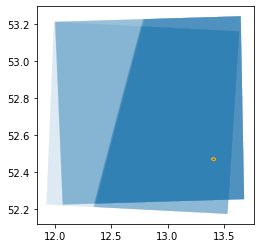

In [14]:
deduped = products_gdf.drop_duplicates(subset='beginposition', keep='first')
ax = deduped.plot(alpha=0.05)
tempelhofer_feld.plot(ax=ax, edgecolor='orange')

How is the data distributed across the year?

<AxesSubplot:xlabel='week'>

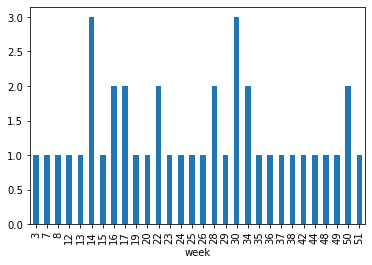

In [15]:
captured_at = deduped['beginposition'].astype('datetime64')
captured_at.groupby(captured_at.dt.isocalendar().week).count().plot(kind='bar')

We need to download all products in the `deduped` dataframe:

In [16]:
len(deduped)

40

In [17]:
import logging
logger = logging.getLogger('sentinelsat')
logger.setLevel(logging.DEBUG)

In [18]:
downloaded, triggered, failed = api.download_all(deduped['uuid'].values, directory_path=base_path.absolute())

In [19]:
len(downloaded), len(triggered), len(failed)

(40, 0, 0)

In [20]:
assert len(downloaded) == len(deduped), 'Still waiting for more products.'

How is the data distributed across the year?

For the NDVI we need bands 4 and 8:

In [21]:
product_paths = list(map(lambda x: x['path'], downloaded.values()))

In [23]:
b04_path, b08_path = sentinel_helpers.scihub_band_paths(product_paths[0], ['B04', 'B08'], '10m')
b04_path, b08_path

('zip+file:///home/jovyan/true-color-image/input/tempelhofer_feld/S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_20191213T120011.zip!/S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_20191213T120011.SAFE/GRANULE/L2A_T33UUU_A023371_20191213T102424/IMG_DATA/R10m/T33UUU_20191213T102421_B04_10m.jp2',
 'zip+file:///home/jovyan/true-color-image/input/tempelhofer_feld/S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_20191213T120011.zip!/S2A_MSIL2A_20191213T102421_N0213_R065_T33UUU_20191213T120011.SAFE/GRANULE/L2A_T33UUU_A023371_20191213T102424/IMG_DATA/R10m/T33UUU_20191213T102421_B08_10m.jp2')

**TODO** We need to do three things:

- Reproject the image into our target geometry
- Create a subset, where [this content on the rasterio homepage](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html) may help
- Make sure to mask clouds or keep the cloud mask somewhere ← **!!!TBD!!!**

In [24]:
subset_path = base_path / 'subset'
subset_path.mkdir(exist_ok=True, parents=True)

In [26]:
cloud_mask = sentinel_helpers.scihub_cloud_mask(product_paths[0])

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [27]:
import rasterio as r
import rasterio.mask
import rasterio.plot as rplt
import numpy as np
from sentinel_helpers import scihub_normalize_range

The finally helpful tip for clipping came from [this website](https://automating-gis-processes.github.io/CSC/notebooks/L5/clipping-raster.html).

**TODO** Make sure that we are using the correct range here.

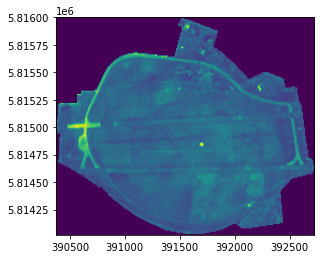

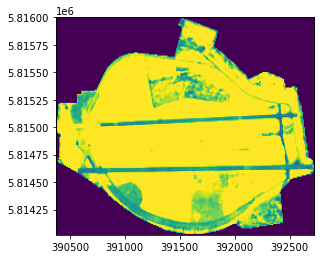

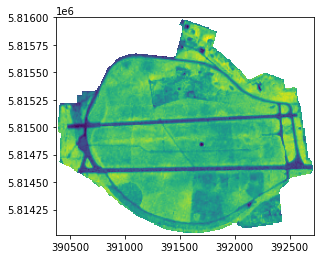

In [30]:
with r.open(b04_path, 'r') as b04, r.open(b08_path, 'r') as b08:
    # we want to only write the bare minimum data necessary to disk
    out_meta = b04.meta.copy()
    
    # we reproject the geojson file we fetched above and convert it so that rasterio
    # can use it as a mask; we subtract the cloud mask
    mask = (tempelhofer_feld.to_crs(out_meta['crs']).iloc[0].geometry - cloud_mask)
    miny, minx, maxy, maxx = mask.bounds
    
    # update the dimensions and save as geotiff, not jp2
    out_meta.update({
        'width': maxx - minx,
        'height': maxy - miny,
        'driver': 'GTiff',
        'dtype': 'float32'
    })    
    out_name = Path(b04_path).name.replace('B04', 'NDVI').replace('.jp2', '.tif')
    
    output_path = Path('output') / out_name
    output_path.parent.mkdir(exist_ok=True, parents=True)
    
    with r.open(output_path, 'w+', **out_meta) as dst:
        # we take only the part out of our source raster that we actually need
        # crop=True clips off the borders
        b04, transform_b04 = rasterio.mask.mask(b04, shapes=[mask], crop=True)
        b08, _ = rasterio.mask.mask(b08, shapes=[mask], crop=True) # we ignore the returned transform because it's identical to the previous one
        
        b04 = scihub_normalize_range(b04).astype('f4') # <- f4 = float32
        b08 = scihub_normalize_range(b08).astype('f4')
        
        # uncomment the following line to see if your masked shape looks correct
        rplt.show(b04, transform=transform_b04)
        rplt.show(b08, transform=transform_b04)
        
        # we want to be able to ignore divide by zero errors so the formula is nicer to write
        np.seterr(divide='ignore', invalid='ignore')
        ndvi = (b08 - b04) / (b08 + b04)
       
        # uncomment the following line to see if we calculated the index correctly
        rplt.show(ndvi, transform=transform_b04)
        
        dst.write(ndvi)